# llc4320 drifters spectra: Lagrangian

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from cmocean import cm
import dask.dataframe as dd
from xhistogram.xarray import histogram

%matplotlib inline
from matplotlib import pyplot as plt
import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.6514157.datarmor0/parcels-502027/libparcels_random_a1f81a7e-21a2-4728-b9c7-4ba9561378ab.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster() # necessary?
    #w = cluster.scale(jobs=18)
    w = cluster.scale(jobs=3)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.0.220:33226 Dashboard: http://10.148.0.220:8787/status,Cluster Workers: 14 Cores: 14 Memory: 223.58 GiB


---
# Lagrangian spectra

## 1. lat x lon binning (i.e. 2D)

In [4]:
# load Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])

In [ ]:
# This works for 2*2 bins

# bin size
dl = 2
# water depth lower bound
depth = 500

###### north ######
# read raw Lagrangian spectra
df = p.load_diagnostic('spectra_uv_T60_mean0')
df.head()

# add bathymetry to dataframe
def interp_bathy(df):
    bathy = ut.load_bathy(15)
    ds = df[['lon','lat']].to_xarray()
    ds_interpolated = bathy.interp(lon=ds['lon'], lat=ds['lat'])
    df_interpolated = ds_interpolated.to_dataframe()[bathy.name]
    return df.assign(**{bathy.name: df_interpolated})
df = df.map_partitions(interp_bathy)

# filter out depth ranges
df = df[df['h']>depth]
df.head()

# bin geographically
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-1, 63, dl)
df['lon'] = (df['lon']+180)%360 - 180
df['lon_cut'] = df['lon'].map_partitions(pd.cut, bins=lon_bins)
df['lat_cut'] = df['lat'].map_partitions(pd.cut, bins=lat_bins)
df = df.reset_index().persist()
E = df.groupby(['lon_cut', 'lat_cut']).agg(['mean', 'count']).compute()

#Converting pandas dataframe in xarray dataset:
index = pd.MultiIndex.from_arrays([E.index.map(lambda v: v[0].mid),
                                   E.index.map(lambda v: v[1].mid)
                                  ], 
                                  names=('lon_cut', 'lat_cut'),
                                 )
ds = (pd.melt(E.set_index(index)
              .drop(columns=['time','lon','lat', 'h', 'trajectory'])
              .reset_index(), id_vars=['lon_cut', 'lat_cut',],
              #var_name='frequency',
             )
      .rename(columns={'lon_cut': 'lon_bins', 'lat_cut': 'lat_bins', 'value': 'E'})
     ).to_xarray().set_index(index=['lon_bins', 'lat_bins']).unstack()
ds = ds.drop(['variable_0','variable_1'])
ds_north = ds
print(ds)

# read raw Lagrangian spectra
df = p.load_diagnostic('spectra_uv_T60_mean0')
df.head()

# add bathymetry to dataframe
def interp_bathy(df):
    bathy = ut.load_bathy(15)
    ds = df[['lon','lat']].to_xarray()
    ds_interpolated = bathy.interp(lon=ds['lon'], lat=ds['lat'])
    df_interpolated = ds_interpolated.to_dataframe()[bathy.name]
    return df.assign(**{bathy.name: df_interpolated})
df = df.map_partitions(interp_bathy)

# filter out depth ranges
df = df[df['h']>depth]
df.head()

# bin geographically
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-61, 3, dl)    
df['lon'] = (df['lon']+180)%360 - 180
df['lon_cut'] = df['lon'].map_partitions(pd.cut, bins=lon_bins)
df['lat_cut'] = df['lat'].map_partitions(pd.cut, bins=lat_bins)
df = df.reset_index().persist()
E = df.groupby(['lon_cut', 'lat_cut']).agg(['mean', 'count']).compute()

#Converting pandas dataframe in xarray dataset:
index = pd.MultiIndex.from_arrays([E.index.map(lambda v: v[0].mid),
                                   E.index.map(lambda v: v[1].mid)
                                  ], 
                                  names=('lon_cut', 'lat_cut'),
                                 )
ds = (pd.melt(E.set_index(index)
              .drop(columns=['time','lon','lat', 'h', 'trajectory'])
              .reset_index(), id_vars=['lon_cut', 'lat_cut',],
              #var_name='frequency',
             )
      .rename(columns={'lon_cut': 'lon_bins', 'lat_cut': 'lat_bins', 'value': 'E'})
     ).to_xarray().set_index(index=['lon_bins', 'lat_bins']).unstack()
ds = ds.drop(['variable_0','variable_1'])
ds_south = ds   
print(ds)

# together
ds_all = xr.concat([ds_south, ds_north.where(ds_north.lat_bins>0,drop=True)], dim="lat_bins")

# store diagnostic
p.store_diagnostic('Lagrangian_weight_lat_lon_2deg', ds_all, overwrite=True)

# Account for Lagrangian weights

In [5]:
# load spectra
ds_c = p.load_diagnostic('Lagrangian_weight_lat_lon_2deg.zarr')
ds_c = ds_c.E.where(ds_c.E>0)
ds_c

<xarray.DataArray 'E' (lon_bins: 179, lat_bins: 61)>
dask.array<where, shape=(179, 61), dtype=float64, chunksize=(179, 61), chunktype=numpy.ndarray>
Coordinates:
  * lat_bins  (lat_bins) float64 -60.0 -58.0 -56.0 -54.0 ... 54.0 56.0 58.0 60.0
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0

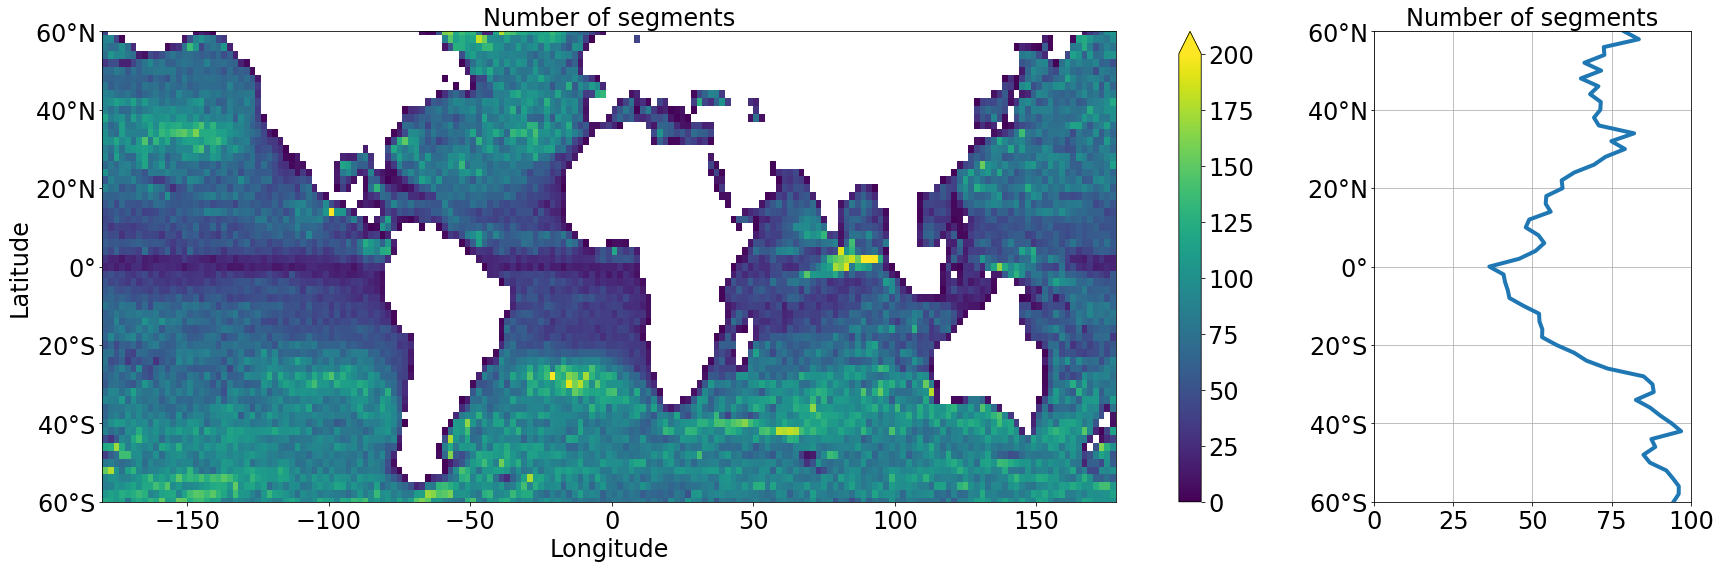

In [9]:
# load spectra
from matplotlib import gridspec
font_size = 24

fig, ax = plt.subplots(figsize=(24,8))

gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1]) 
ax = plt.subplot(gs[0])
cax = ds_c.plot(x='lon_bins',cmap='viridis',vmin=0,vmax=200, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='max', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('', fontsize=font_size)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
# Label, size
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Longitude',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Number of segments',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(gs[1])
ds_c.mean('lon_bins').plot(y='lat_bins',linewidth=4)
ax.set_xlim(0., 100.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Number of segments',fontsize=font_size)

plt.tight_layout()

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Segment_distribution.png')

## Comparison

In [6]:
# load raw spectra (zonally averaged)
ds_L = (p.load_diagnostic('spectra_uv_T60_mean0_lat.zarr')
        .rename({'E':'E_Lagrangian'})
       )

ds_E = (xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat.zarr'))
        .rename({'E_SSUV_T60': 'E_Eulerian'})
       )

ds = xr.merge([ds_L, ds_E])

E_Lagrangian = ds.E_Lagrangian
E_Eulerian = ds.E_Eulerian
df=E_Eulerian.frequency[1]-E_Eulerian.frequency[0]
# Inertial frequency
f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_Eulerian.lat_bins))
f_cpd_llc = f_llc*86400/2./np.pi
E_Lagrangian

<xarray.DataArray 'E_Lagrangian' (lat_bins: 119, frequency: 1440)>
dask.array<open_dataset-867de569f965005a954fb435aa98a7dbE, shape=(119, 1440), dtype=float64, chunksize=(60, 720), chunktype=numpy.ndarray>
Coordinates:
  * frequency  (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bins   (lat_bins) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5

In [7]:
# KE already computed from 2D binned spectra
E = p.load_diagnostic('spectra_uv_T60_mean0_lat_lon_bands.zarr')
E_L = E.E

E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat_lon_bands_from_2Dbin_spectra.zarr'))
E_E = E.E_SSUV
E_E

<xarray.DataArray 'E_SSUV' (frequency_band: 14, lon_bins: 359, lat_bins: 119)>
dask.array<open_dataset-f0629df1cdbcb8e6d61f93a6987f7e92E_SSUV, shape=(14, 359, 119), dtype=float64, chunksize=(1, 45, 30), chunktype=numpy.ndarray>
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5

In [8]:
E_E_interp = E_E.interp(lat_bins = ds_c.lat_bins,lon_bins = ds_c.lon_bins)
E_E_weights = (E_E_interp*ds_c).mean('lon_bins')/ds_c.mean('lon_bins')
E_E_weights

<xarray.DataArray (frequency_band: 14, lat_bins: 61)>
dask.array<truediv, shape=(14, 61), dtype=float64, chunksize=(1, 61), chunktype=numpy.ndarray>
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -60.0 -58.0 -56.0 ... 56.0 58.0 60.0

Text(0.5, 1.0, 'LLC4320 (Lagrangian, raw)')

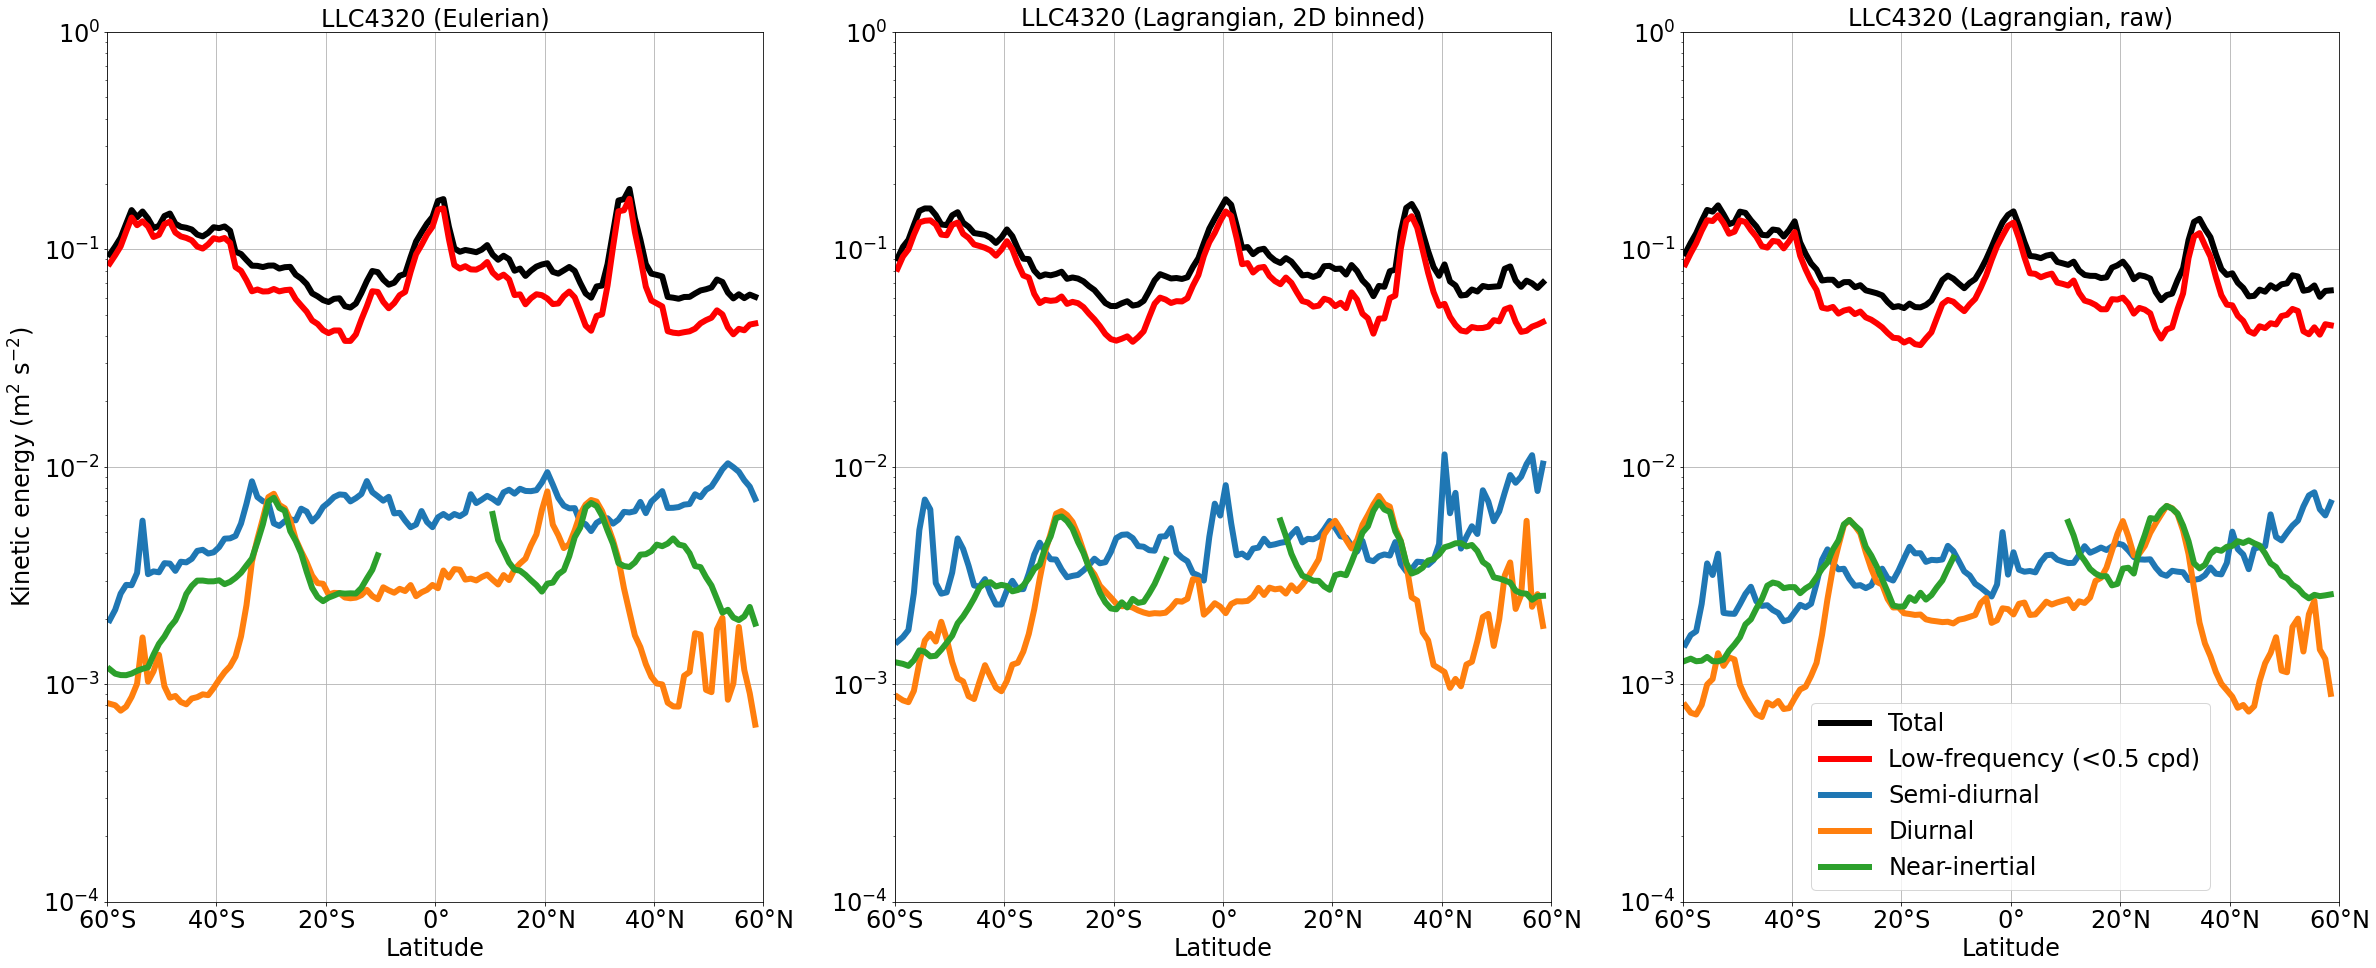

In [12]:
# compare each component by applying windowing
labels = ['Total', 'Low-frequency (<0.5 cpd)','High-frequency (>0.5 cpd)','Semi-diurnal', 'Diurnal', 'Near-inertial']
linewidth = 6
fontsize = 24

fig, ax = plt.subplots(figsize=(40,16))

ax = plt.subplot(131)
E_E.sel(frequency_band='total').mean('lon_bins').plot(color='black', label=labels[0], linewidth=linewidth) # total energy
E_E.sel(frequency_band='low').mean('lon_bins').plot(color='red', label=labels[1], linewidth=linewidth) # low energy
E_E.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').plot(label=labels[3], linewidth=linewidth) # energy around semi-diurnal frequencies
E_E.sel(frequency_band='diurnal_0dot1').mean('lon_bins').plot(label=labels[4], linewidth=linewidth) # energy around diurnal frequencies
E_E.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(abs(E_L.lat_bins)>10).plot(label=labels[5], linewidth=linewidth) # energy around f
#ax.legend(prop={'size': fontsize}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_yscale('log')
ax.set_ylim([1e-4,1e0])
# Label, size
ax.set_xlabel('Latitude',fontsize=fontsize)
ax.set_ylabel('',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('LLC4320 (Eulerian)',fontsize=fontsize)
ax.set_ylabel('Kinetic energy (m$^2$ s$^{-2}$)',fontsize=fontsize)

ax = plt.subplot(132)
E_L.sel(frequency_band='total').mean('lon_bins').plot(color='black', label=labels[0], linewidth=linewidth) # total energy
E_L.sel(frequency_band='low').mean('lon_bins').plot(color='red', label=labels[1], linewidth=linewidth) # low energy
E_L.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').plot(label=labels[3], linewidth=linewidth) # energy around semi-diurnal frequencies
E_L.sel(frequency_band='diurnal_0dot1').mean('lon_bins').plot(label=labels[4], linewidth=linewidth) # energy around diurnal frequencies
E_L.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(abs(E_L.lat_bins)>10).plot(label=labels[5], linewidth=linewidth) # energy around f
#ax.legend(prop={'size': fontsize}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_yscale('log')
ax.set_ylim([1e-4,1e0])
# Label, size
ax.set_xlabel('Latitude',fontsize=fontsize)
ax.set_ylabel('',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('LLC4320 (Lagrangian, 2D binned)',fontsize=fontsize)

ax = plt.subplot(133)
(E_Lagrangian*df).sum(dim='frequency').plot(color='black', label=labels[0], linewidth=linewidth) # total energy
(E_Lagrangian.where((abs(E_Lagrangian.frequency)<0.5) , other=0.)*df).sum(dim='frequency').plot(color='red', label=labels[1], linewidth=linewidth) # total energy
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>1.9) & (abs(E_Lagrangian.frequency)<2.1) , other=0.)*df).sum(dim='frequency').plot(label=labels[3], linewidth=linewidth) # energy around semi-diurnal frequencies
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>0.9) & (abs(E_Lagrangian.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(label=labels[4], linewidth=linewidth) # energy around diurnal frequencies
(E_Lagrangian.where(abs(E_Lagrangian.frequency+f_cpd_llc)<.1, other=0.)*df).sum(dim='frequency').where(abs(E_Lagrangian.lat_bins)>10).plot(label=labels[5], linewidth=linewidth) # energy around f
ax.legend(prop={'size': fontsize}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_yscale('log')
ax.set_ylim([1e-4,1e0])
# Label, size
ax.set_xlabel('Latitude',fontsize=fontsize)
#ax.set_ylabel('Kinetic energy (m$^2$ s$^{-2}$)',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('LLC4320 (Lagrangian, raw)',fontsize=fontsize)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': font_size})

#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_Lagrangian.png')

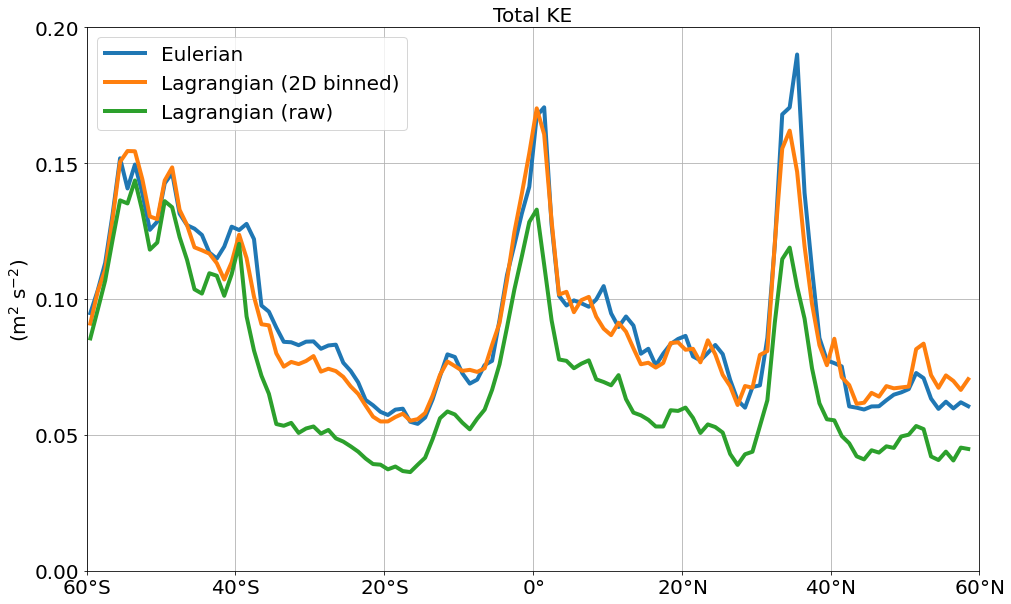

In [28]:
labels = ['Eulerian', 'Lagrangian (2D binned)','Lagrangian (raw)']
font_size = 20
upper_limit= 0.2

fig, ax = plt.subplots(figsize=(16,10))

ax = plt.subplot(111)
E_E.sel(frequency_band='total').mean('lon_bins').plot(color='tab:blue', label=labels[0], linewidth=4) # total energy
E_L.sel(frequency_band='total').mean('lon_bins').plot(color='tab:orange', label=labels[1], linewidth=4) # total energy
(E_Lagrangian.where((abs(E_Lagrangian.frequency)<0.5) , other=0.)*df).sum(dim='frequency').plot(color='tab:green', label=labels[2], linewidth=4,ls='-') # total energy
ax.legend(prop={'size': font_size}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.2])
ax.set_yticks([0,0.05,0.1,0.15,0.2])
# Label, size
ax.set_xlabel('',fontsize=font_size)
ax.set_ylabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Total KE',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Total_KE_LLC_Eulerian_Lagrangian.png')

Text(0.5, 1.0, '')

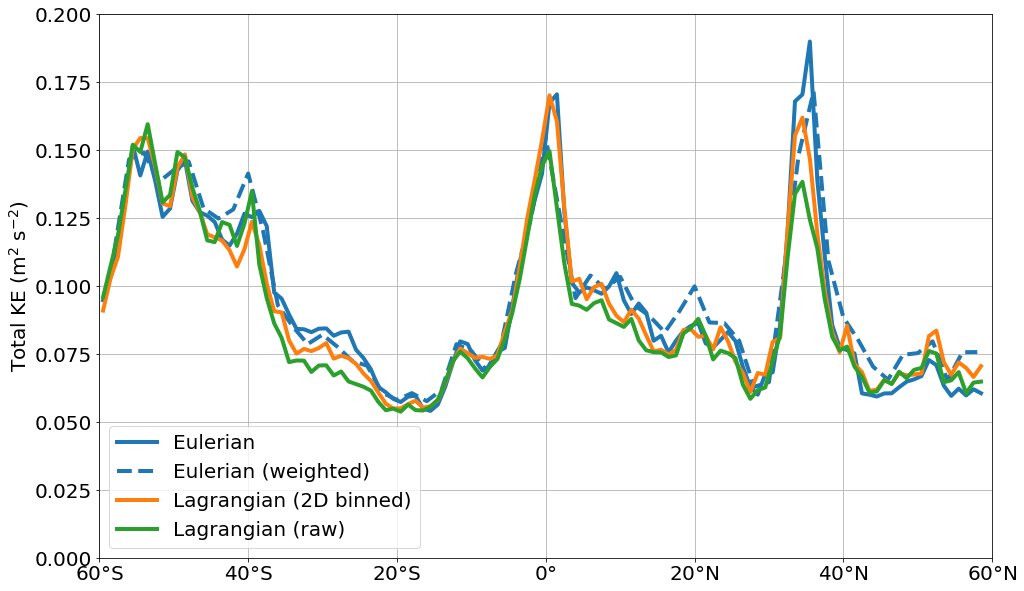

In [16]:
labels = ['LLC4320(Eulerian)', 'LLC4320(Eulerian,weighted)', 'LLC4320(Lagrangian, 2D binned)', 'LLC4320(Lagrangian, raw)']
labels = ['Eulerian', 'Eulerian (weighted)','Lagrangian (2D binned)','Lagrangian (raw)']


font_size = 20

fig, ax = plt.subplots(figsize=(16,10))

ax = plt.subplot(111)
E_E.sel(frequency_band='total').mean('lon_bins').plot(color='tab:blue', label=labels[0], linewidth=4) # total energy
E_E_weights.sel(frequency_band='total').plot(color='tab:blue', label=labels[1], linewidth=4,ls='--') 
E_L.sel(frequency_band='total').mean('lon_bins').plot(color='tab:orange', label=labels[2], linewidth=4) # total energy
(E_Lagrangian.where((abs(E_Lagrangian.frequency)<12) , other=0.)*df).sum(dim='frequency').plot(color='tab:green', label=labels[3], linewidth=4,ls='-') # total energy
ax.legend(prop={'size': font_size}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.2])
# Label, size
ax.set_xlabel('',fontsize=font_size)
ax.set_ylabel('Total KE (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)
#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Weighted_KE_lat.png')

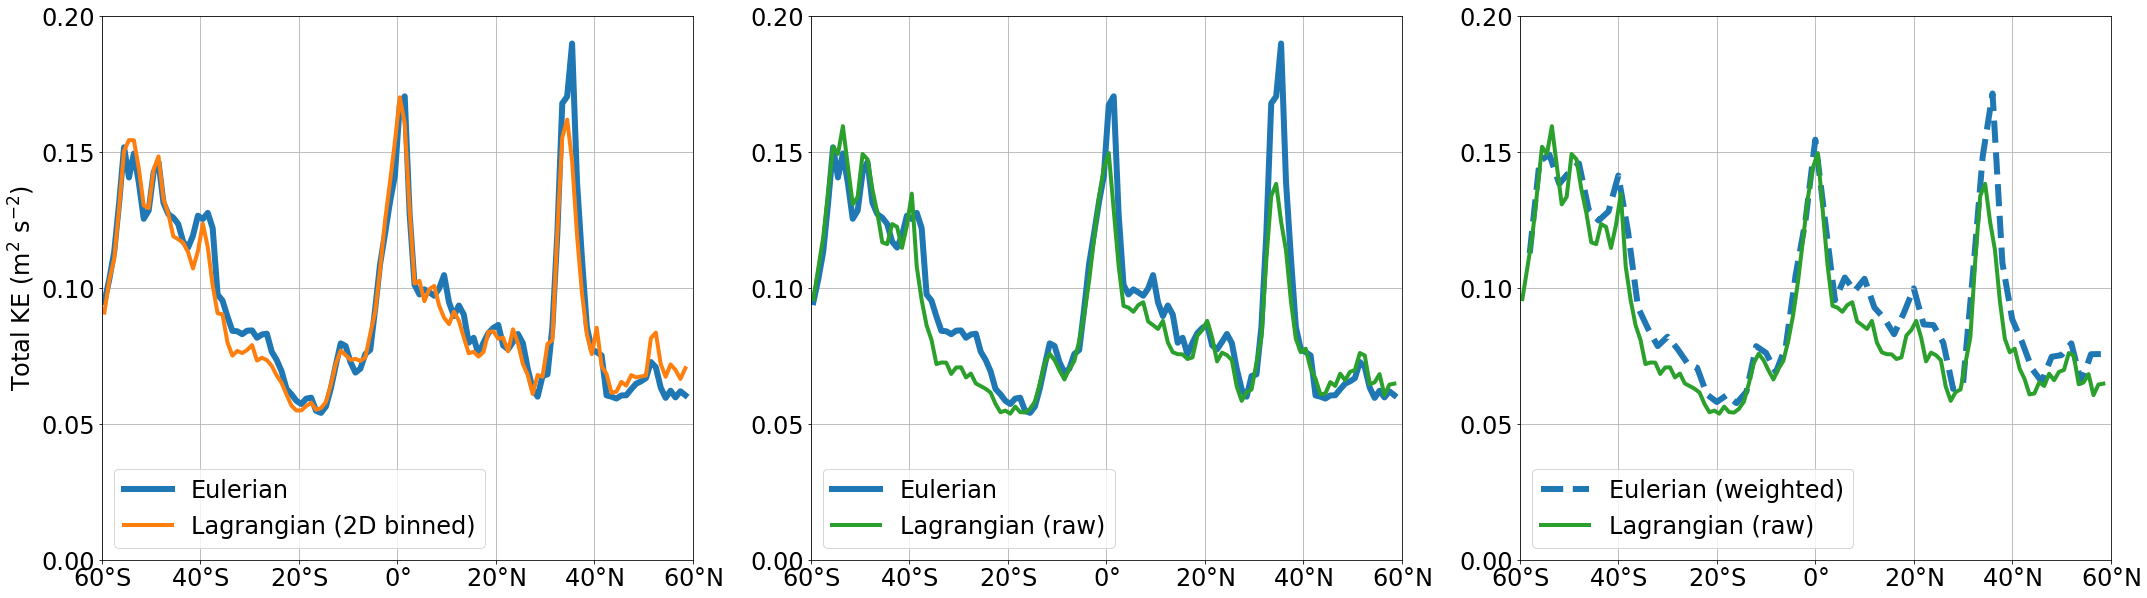

In [19]:
labels = ['Eulerian', 'Eulerian (weighted)','Lagrangian (2D binned)','Lagrangian (raw)']
font_size = 24

fig, ax = plt.subplots(figsize=(36,10))
ax = plt.subplot(131)
E_E.sel(frequency_band='total').mean('lon_bins').plot(color='tab:blue', label=labels[0], linewidth=6) # total energy
E_L.sel(frequency_band='total').mean('lon_bins').plot(color='tab:orange', label=labels[2], linewidth=4) # total energy
ax.legend(prop={'size': font_size}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.2])
ax.set_yticks([0., 0.05, 0.1, 0.15, 0.20])
# Label, size
ax.set_xlabel('',fontsize=font_size)
ax.set_ylabel('Total KE (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)
ax.legend(loc='lower left', prop={'size': font_size})

ax = plt.subplot(132)
E_E.sel(frequency_band='total').mean('lon_bins').plot(color='tab:blue', label=labels[0], linewidth=6) # total energy
(E_Lagrangian.where((abs(E_Lagrangian.frequency)<12) , other=0.)*df).sum(dim='frequency').plot(color='tab:green', label=labels[3], linewidth=4,ls='-') # total energy
ax.legend(prop={'size': font_size}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.2])
ax.set_yticks([0., 0.05, 0.1, 0.15, 0.20])
# Label, size
ax.set_xlabel('',fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)
ax.legend(loc='lower left', prop={'size': font_size})

ax = plt.subplot(133)
E_E_weights.sel(frequency_band='total').plot(color='tab:blue', label=labels[1], linewidth=6,ls='--') 
(E_Lagrangian.where((abs(E_Lagrangian.frequency)<12) , other=0.)*df).sum(dim='frequency').plot(color='tab:green', label=labels[3], linewidth=4,ls='-') # total energy
ax.legend(prop={'size': font_size}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.2])
ax.set_yticks([0., 0.05, 0.1, 0.15, 0.20])
# Label, size
ax.set_xlabel('',fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)
ax.legend(loc='lower left', prop={'size': font_size})

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Weighted_KE_comparison_lat.png')

In [21]:
E_L_interp = (E_Lagrangian.where((abs(E_Lagrangian.frequency)<12) , other=0.)*df).sum(dim='frequency').interp(lat_bins = ds_c.lat_bins)
E_L_interp

<xarray.DataArray (lat_bins: 61)>
dask.array<dask_aware_interpnd, shape=(61,), dtype=float64, chunksize=(61,), chunktype=numpy.ndarray>
Coordinates:
  * lat_bins  (lat_bins) float64 -60.0 -58.0 -56.0 -54.0 ... 54.0 56.0 58.0 60.0

In [33]:
E_E_weights_interp = E_E_weights.sel(frequency_band='total').interp(lat_bins = ds.lat_bins)
E_E_weights_interp

<xarray.DataArray (lat_bins: 119)>
dask.array<dask_aware_interpnd, shape=(119,), dtype=float64, chunksize=(119,), chunktype=numpy.ndarray>
Coordinates:
    frequency_band  <U5 'total'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5

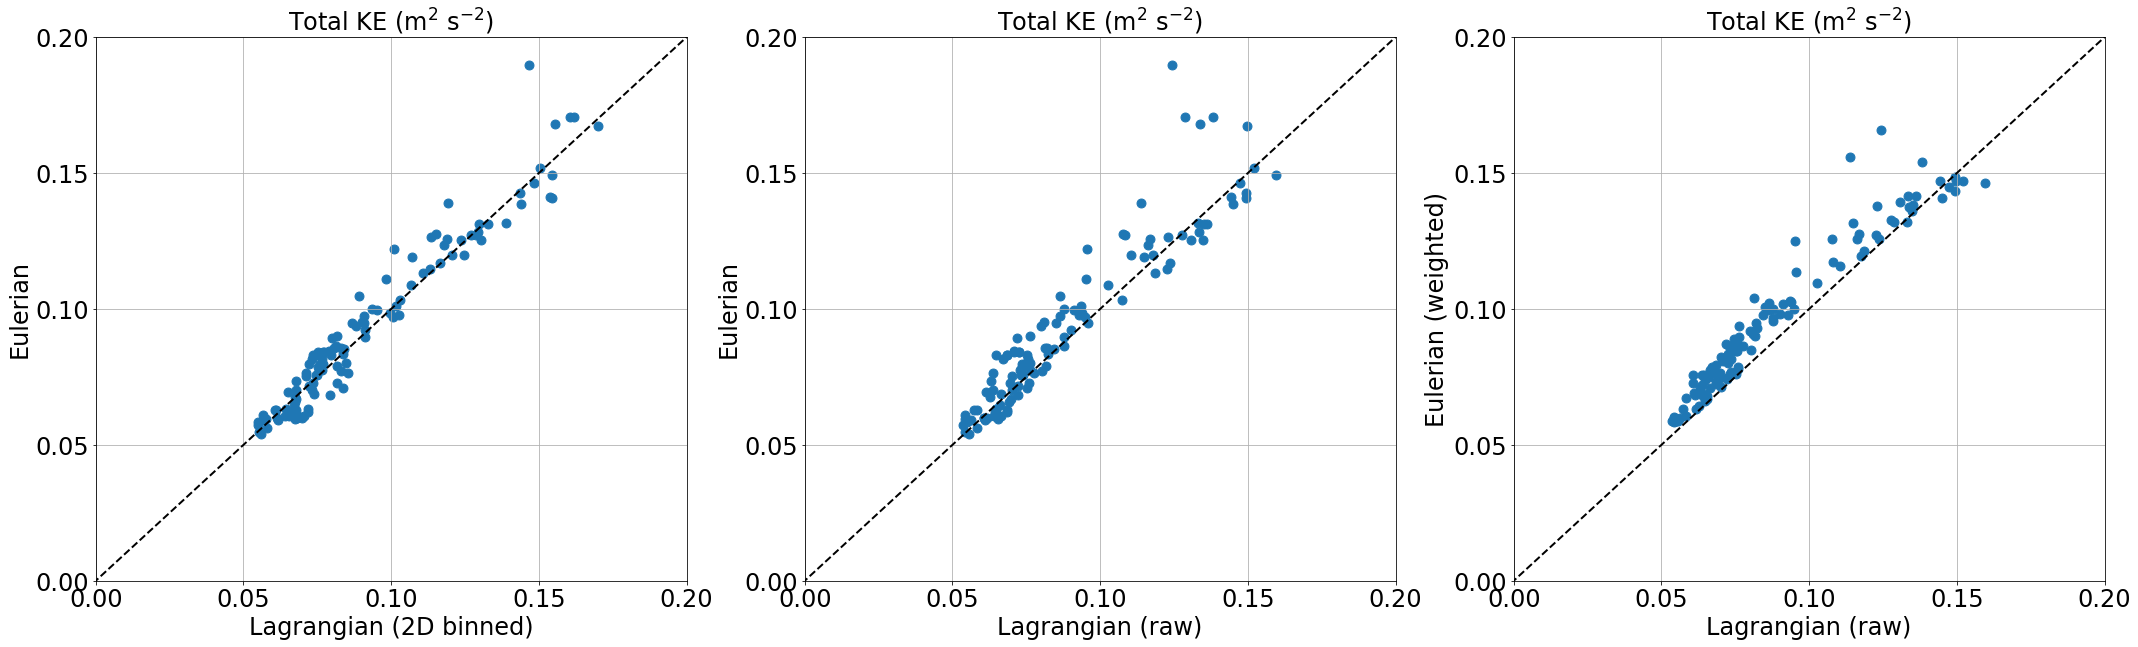

In [39]:
font_size = 24
s_size = 80
fig, ax = plt.subplots(figsize=(36,10))
ax = plt.subplot(131)
ax.scatter( E_L.sel(frequency_band='total').mean('lon_bins'), E_E.sel(frequency_band='total').mean('lon_bins'), s=s_size)
ax.grid(); 
ax.set_xlim(0.,0.2); ax.set_ylim(0.,0.2)
ax.set_xticks([0,0.05,0.1,0.15,0.2])
ax.set_yticks([0,0.05,0.1,0.15,0.2])
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('Total KE (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Eulerian',fontsize=font_size)
ax.set_xlabel('Lagrangian (2D binned)',fontsize=font_size)

ax = plt.subplot(132)
ax.scatter( (E_Lagrangian.where((abs(E_Lagrangian.frequency)<12) , other=0.)*df).sum(dim='frequency'), E_E.sel(frequency_band='total').mean('lon_bins'), s=s_size)
ax.grid(); 
ax.set_xlim(0.,0.2); ax.set_ylim(0.,0.2)
ax.set_xticks([0,0.05,0.1,0.15,0.2])
ax.set_yticks([0,0.05,0.1,0.15,0.2])
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('Total KE (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Eulerian',fontsize=font_size)
ax.set_xlabel('Lagrangian (raw)',fontsize=font_size)

ax = plt.subplot(133)
#ax.scatter( E_L_interp, E_E_weights.sel(frequency_band='total'), s=50, label=labels[1])
ax.scatter( (E_Lagrangian.where((abs(E_Lagrangian.frequency)<12) , other=0.)*df).sum(dim='frequency'), E_E_weights_interp, s=s_size)
ax.grid(); 
ax.set_xlim(0.,0.2); ax.set_ylim(0.,0.2)
ax.set_xticks([0,0.05,0.1,0.15,0.2])
ax.set_yticks([0,0.05,0.1,0.15,0.2])
ax.plot(lims, lims, color="k", ls="--", linewidth=2)
ax.set_title('Total KE (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Eulerian (weighted)',fontsize=font_size)
ax.set_xlabel('Lagrangian (raw)',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Weighted_KE_comparison_scatter_lat.png')

In [27]:
R = xr.corr(E_L.sel(frequency_band='total').mean('lon_bins'), E_E.sel(frequency_band='total').mean('lon_bins'),
            dim=['lat_bins']
           )
R.values

array(0.96977316)

In [28]:
R = xr.corr((E_Lagrangian.where((abs(E_Lagrangian.frequency)<12) , other=0.)*df).sum(dim='frequency'), E_E.sel(frequency_band='total').mean('lon_bins'),
            dim=['lat_bins']
           )
R.values

array(0.93750257)

In [35]:
R = xr.corr((E_Lagrangian.where((abs(E_Lagrangian.frequency)<12) , other=0.)*df).sum(dim='frequency'), E_E_weights_interp,
            dim=['lat_bins']
           )
R.values

array(0.96557738)

## Close cluster

In [41]:
cluster.close()